In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import re
from keras import ops
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import os
from google.colab import drive
from sklearn.metrics import roc_curve, auc

In [6]:
# Mounting Google Drive to collab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Importing the data
fake_news = pd.read_csv('drive/MyDrive/MLFinalProject/Fake.csv')
true_news = pd.read_csv('drive/MyDrive/MLFinalProject/True.csv')

In [8]:
# Analyzing the fake news data
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
# Analyzing the true news data
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [10]:
# Adding column to each dataframe that will classify the corresponding news as either fake (0) or true (1)
fake_news['designation'] = 0
true_news['designation'] = 1

Because we are dealing with a binary classification, we need some sort of designation to identify which news is fake and which news is true. In order to do this, we add a new column to each dataframe identifying which news is true and which is fake. The classifier is binary so news will either be 1 for true news or 0 for fake news.

In [11]:
# Merging the two datasets
news = pd.concat([fake_news, true_news], axis=0)
news.head()

,title,text,subject,date,designation
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [12]:
# Cleaning the data
news=news.drop(['title','subject','date'], axis=1)
news.head()

,text,designation
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [13]:
# Standardizing the data; removing special characters, numbers, urls, and making everything lowercase


pattern1 = r'[^\w\s]'
news['text'] = news['text'].apply(lambda x: re.sub(pattern1, '', x))                   # Removing Special characters

news['text'] = news['text'].str.replace('\d+', ' ')                                    # Removing numbers

pattern2 = r'https://\S+|www\.\S+'
news['text'] = news['text'].apply(lambda x: re.sub(pattern2, '', x))                   # Removing Urls

news['text'] = news['text'].str.lower()                                                # Making all letters lowercase

news.head()

,text,designation
0,donald trump just couldn t wish all americans ...,0
1,house intelligence committee chairman devin nu...,0
2,on friday it was revealed that former milwauke...,0
3,on christmas day donald trump announced that h...,0
4,pope francis used his annual christmas day mes...,0


In [14]:
# Splitting the columns into vectors
x = news['text']
y = news['designation']

The previous four blocks of code are for cleaning the data. Firstly the two dataframes (true_news and fake_news) were merged into a new dataframe called news. This makes it easier to clean the data as we do not need to repeat steps for both true_news and fake_news but instead only do cleaning steps one time in the merged dataframe. After merging the data, we dropped the columns titled: 'title', 'subject', and 'date'. This isolates the necessary data that we need for the model, which are the columns 'text' and 'designation'. Next, we took steps to standardize the text data to make all the text data standard meaning that all the text was completely rid of special characters, numbers, urls, and most importantly making all the letters lowercase. Lastly, we split the columns of the news dataframe into two different vectors; x for the text data and y for the fake or true designation data.

In [15]:
# Creating the transformer block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [16]:
# Creating the embedding Layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [17]:
# Converting text to sequence using tokenizer
vocab_size = 25000
maxlen = 200
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(news['text'])
sequences = tokenizer.texts_to_sequences(news['text'])
x = pad_sequences(sequences, maxlen=maxlen)

The previous block of code is very important, as it converts the strings of text into an array of numbers. Each word in a string of text is converted into a new number with there being a limit on the amount of words that can be stored determined by the vocab_size variable, so in this model, there are 25000 unique words that can be stored. Later, the tokenizer can be reversed so that we can see the string of text that is stored within any unique data point.

In [18]:
# Creating the train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

This block of code splits the text data and the designation data into a training set and a testing set. It randomly selects 50% of each data and designates that to be the training set, which will eventually train the model, the other 50% is designated as the test set which will be used to test the model and compute the validation accuracy.

In [19]:
# Creating the model
embed_dim = 32
num_heads = 2
ff_dim = 32

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Here we are creating the model. The model calls both the embedding layer and transformer block that are defined above. The model structure is fairly standard but it is important that the output layer only has an output of 1 unit and the activation function is sigmoid as we are doing a binary classification.

In [20]:
# Analyzing the model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 200, 32)             │         806,400 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 200, 32)             │          10,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 817,737 (3.12 MB)

 Trainable params: 817,737 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Compiling and fitting the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 150s 204ms/step - accuracy: 0.9976 - loss: 0.0081 - val_accuracy: 0.9877 - val_loss: 0.0563
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 126s 180ms/step - accuracy: 0.9992 - loss: 0.0020 - val_accuracy: 0.9878 - val_loss: 0.0759
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 143s 181ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9841 - val_loss: 0.0987
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 141s 179ms/step - accuracy: 1.0000 - loss: 4.5833e-04 - val_accuracy: 0.9859 - val_loss: 0.0852
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 143s 182ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9873 - val_loss: 0.0799
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 141s 181ms/step - accuracy: 0.9999 - loss: 4.5803e-04 - val_accuracy: 0.9878 - val_loss: 0.0711
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 139s 176ms/step - accuracy: 0.9998 - loss: 5.2837e-04 - val_accuracy: 0.9862 - val_loss: 0.0772
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 131s 160ms/step - accura

Here we are compiling and fitting the model with the training and test data that we created above. As you can see the model i quite accurate with the accuracy value never dipping below 0.99, but more importantly the validation accuracy is also very accurate never dipping below 0.98. This validation accuracy means that the model is 98% accurate when trying to predict whether or not the test data that we have given it is true or fake.

In [40]:
# Computing predicted values
y_pred = model.predict(x_test)

702/702 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step


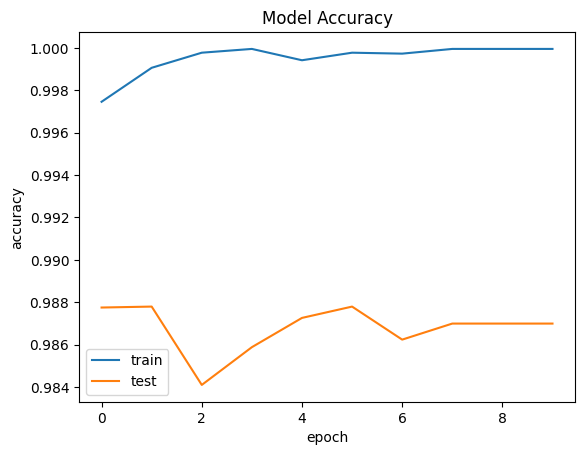

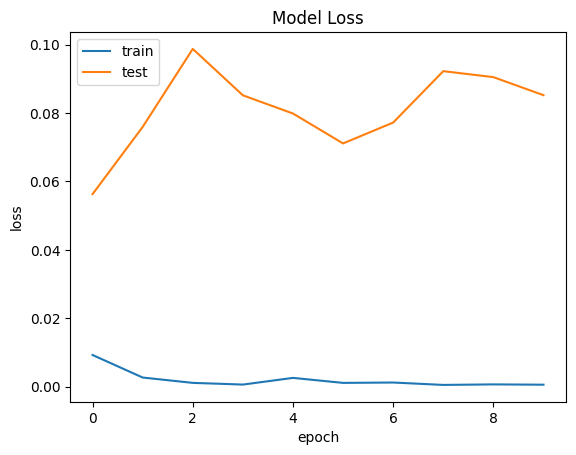

Text(0, 0.5, 'Predicted Values')

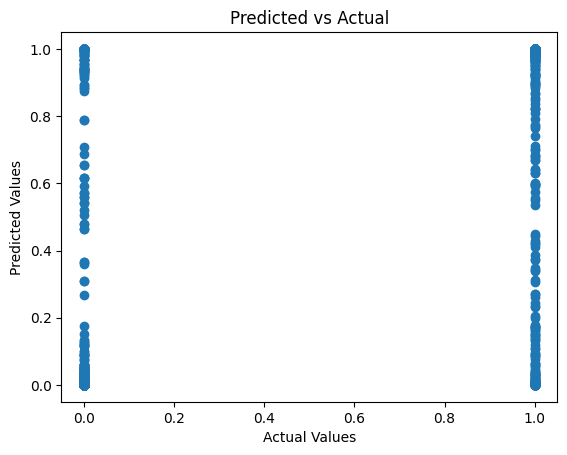

In [42]:
# Plotting Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Plotting Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Plotting Binary response
plt.scatter(y_test,y_pred)
plt.title("Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

Here we have plotted the model accuracy, model loss, and the predicted values vs. actual values. The model accuracy plot is useful for visualizing the accuracy and validation accuracy of the model throughout each epoch. The model loss plot is useful for visualizing the loss and validation loss throughout the epochs. The predicted vs actual plot is not particularly useful but it can be used to visualize if the model is better at predicting fake or true news, which can be used to tune the model.

In [24]:
# computing MC Dropout samples
y_samples = np.stack([model(x_test[:2000],training=True)
                      for sample in range(100)])

In [25]:
# Checking the shape of the MC-Dropout samples to make sure the model is correct
print(y_samples.shape)

(100, 2000, 1)


In [28]:
# Computing the prediciton interval of the MC-Dropout
tau = 10
y_samples_mean = y_samples.mean(axis=0).reshape(-1)
y_samples_sd = np.sqrt(y_samples.var(axis=0)+1/tau).reshape(-1)
low95 = y_samples_mean - 1.96*y_samples_sd*np.sqrt(1/2000)
high95 = y_samples_mean + 1.96*y_samples_sd*np.sqrt(1/2000)
pi_95 = np.stack((low95, high95))

In [29]:
# Finding the case with the widest gap in the respective prediction interval
# and printing the original text of that case
argmax = np.argmax(pi_95[:,1]-pi_95[:,0],axis=0)
print(pi_95[argmax])
print(x_test[argmax])
original_text = tokenizer.sequences_to_texts(x_test)
print(original_text[argmax])

[0.01414936 1.0126935  1.0114815  ... 0.01418489 0.01490649 1.0136822 ]
[ 2783  1028    67    19  2675    15  2966   986     2     1    84    70
  3965  4901  1690     2    16   415   168     8  1376   477     1   221
    13  1523    41    44  2304     8     1 10959  3057    18     4  1877
     8   924     5    41   103  1999    53     3     1  2213  1495     1
   221  1953   650    38     4   257  3115   150  1523     5  4186   181
    31  1575     1   247   178   911   309    97   536   124   120   161
  1484     1    87    71  3835  2496     7    97   306    23   833   132
  6325  3017  4186    31    13   656     8     1  1542     3  2189    61
    21    15  1523     5   450    67  1267   664     2    16     1   534
     3   890   124   120   834 21869     4   105   319    96  5758   264
   297 22905 22059     4   924  6108     5    78  9824  1570    16    11
  2728    10    19   104  9243   255     8   206     5   208    15   734
    37  1353  3294    15     1   655     3   156  39

In [30]:
# Finding the case with the smallest gap in the respective prediction interval
# and printing the original text of that case
argmin = np.argmin(pi_95[:,1]-pi_95[:,0],axis=0)
print(pi_95[argmin])
print(x_test[argmin])
original_text = tokenizer.sequences_to_texts(x_test)
print(original_text[argmin])

[-0.01356934  0.98497474  0.98376137 ... -0.01353374 -0.01281278
  0.9859636 ]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
   966   740   957   191  1863  3300 20626  1508    25   485    61     3
    81  1456  7074  4006     6  1016   801     5  7058   165    18     9
   200   223   126    81  5584  1242     8   480  9522 10452     9   238
   682   112  2428     1  2932     7    17  2186     8    37    16     9
   366   245     8   824  3300  2244     2     1  9930    20     1  4980
  2384   137     6   106    60    18     4  2025   608    89     1   366
  2973     5    89     1   970  3300   358     8     2   313     1  1718
     6  3997   123 13196     5     1  1724   123 21267   505     1   294
   891    10     1  1303  1242     5  1654     1  6090  2828     2     1
  1233     3     1  1697   122     5  5973   

The previous five blocks of code are for computing the MC-dropout, and computing the prediction intervals of the samples from the MC-dropout. From the prediction interval we can use the argmax function to find out which data point has the widest gap in its prediction interval. We can then find that data point and convert the string of number back into text using the tokenizer.sequences_to_texts function to see what the text data was previous to being tokenized. We can see the text in the second to last code block. There is not anything that is jumping off the page from the text that would help in understanding why the prediction interval is so wide. My first thought is that there are many names included in the text, one of which is is Russian name that may or may not be completely unique amongst all of the text data. Other than that, there is nothing else that I can identify that would result in a wide prediction interval, the text is seemingly a fairly regular and standary news entry. Along with the widest prediction interval text, I have also included the prediction interval with the smalleest gap in the final code block.